In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celluloid import Camera
from IPython.display import Audio
import librosa
import torch
from pathlib import Path
from Models.vae import VAE,VAE2D,VAEDeep,VAEDeeper,VAEDeepStable
from datasets import SpectrogramDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [43]:
file_path = Path("/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/SyncSpeech/dataset_16k.npz")
# Load data
data = np.load(file_path, allow_pickle=True)
x = data['x']
y = data['y']
metadata = data['metadata'].tolist()
CLASSES = data['classes']

In [44]:
# # Split data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Create datasets
train_dataset = SpectrogramDataset(x_train, y_train)
val_dataset = SpectrogramDataset(x_val, y_val)

In [45]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
# Train 50 models
num_models = 1

latent_dim = 16

In [46]:
# Get input shape 
x_batch,x_spec_batch, y_batch = next(iter(train_loader))
input_shape = x_spec_batch.shape


model = VAEDeeper(latent_dim,input_shape)

x_hat, z_mean, z_logvar = model(x_spec_batch)

print("Shape of x_hat:", x_hat.shape)

Shape of x_hat: torch.Size([64, 1, 128, 32])


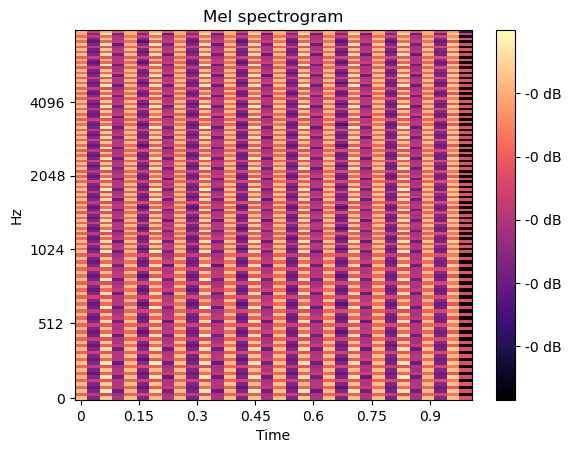

In [47]:
sr = 16000
hop_length = 512
# Display the Mel spectrogram
idx =  np.random.randint(0, x_hat.shape[0])
librosa.display.specshow(librosa.power_to_db(x_hat[idx].squeeze().detach().numpy(), ref=np.max),y_axis='mel', x_axis='time', sr = sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()

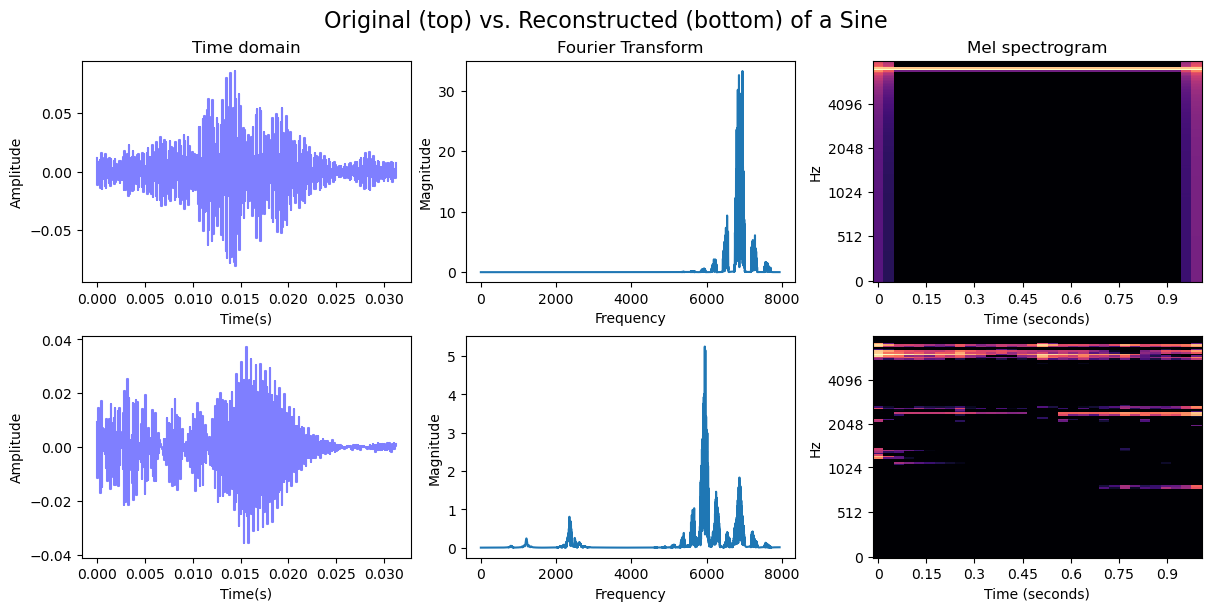

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 16
vae = VAEDeeper(latent_dim, input_shape).to(device)
state_dict = torch.load('./Exports/vae2deeper.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])

fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform[:500], sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon[:500], sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
# plt.savefig('./Figures/Original_vs_Reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
mel_spec = x_hat[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [9]:
Audio(x_batch[idx].squeeze().detach().cpu().numpy(), rate=sr)

In [10]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

In [11]:
idxs =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idxs].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

Audio(waveform, rate=sr)

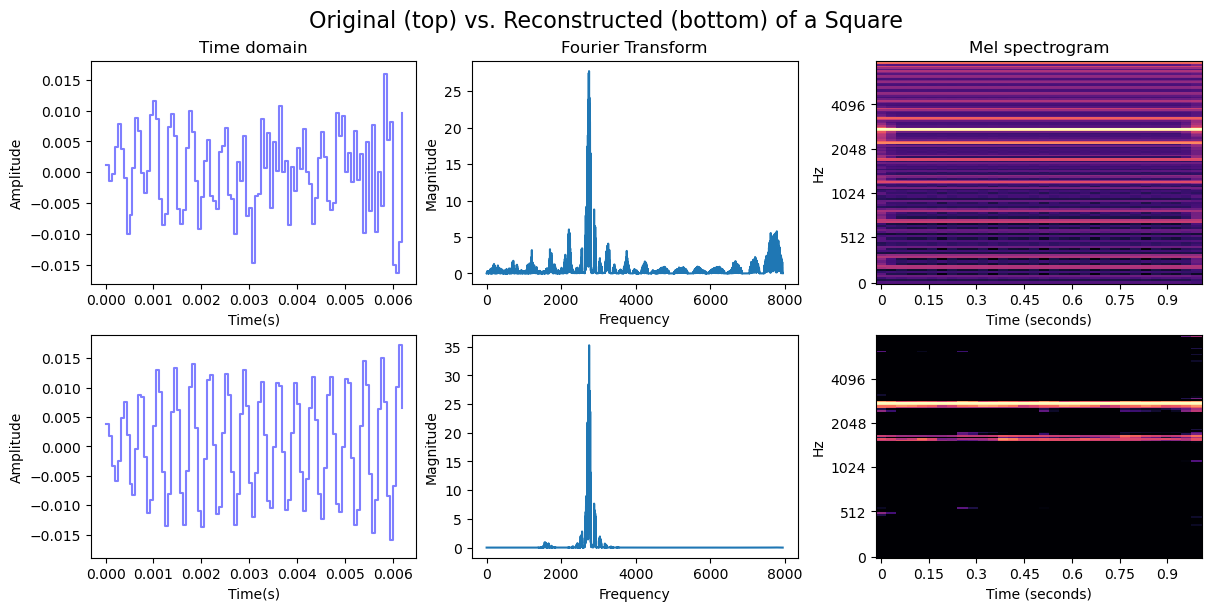

In [75]:
latent_dim = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAEDeep(latent_dim, input_shape).to(device)
state_dict = torch.load(f'./Exports/vae2deep_{latent_dim}.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])
fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform[:100], sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon[:100], sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
plt.savefig('./Figures/Original_vs_Reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

In [113]:
mel_spec = x_hat[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [93]:
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [94]:
Audio(x_batch[idx].squeeze().detach().cpu().numpy(), rate=sr)

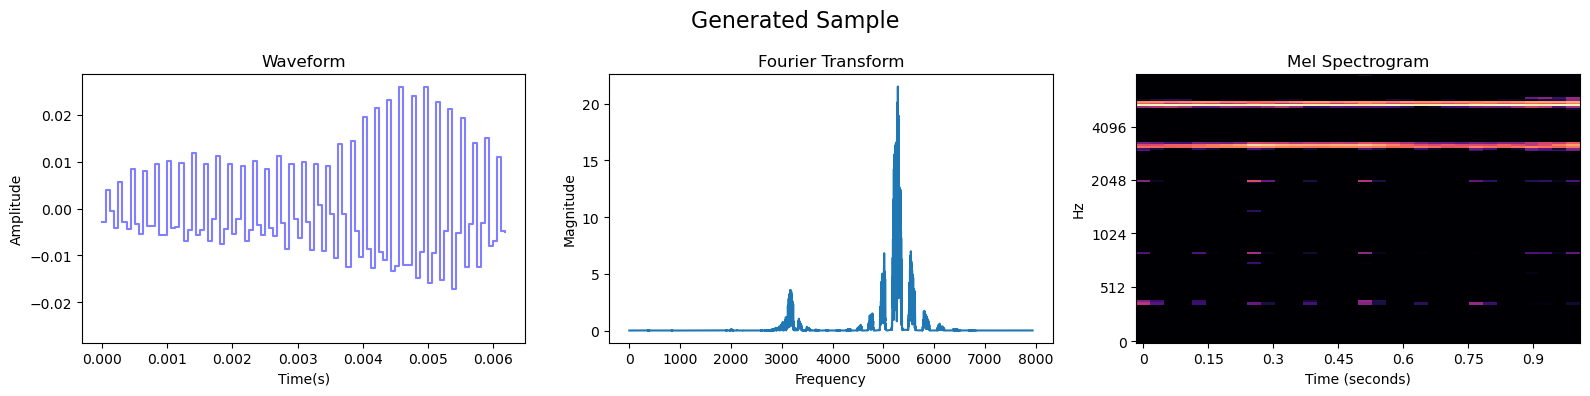

In [66]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

# Random generated mel spectrogram
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

# Waveform
librosa.display.waveshow(waveform[:100], sr=sr, ax=axs[0], alpha=0.5, color='b')
axs[0].set_title('Waveform')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Amplitude')

# Fourier Transform 
ft = np.fft.fft(waveform)
axs[1].plot(np.abs(ft)[:len(ft)//2])
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')

# Mel Spectrogram
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), 
                y_axis='mel', x_axis='s', sr=sr, 
                hop_length=hop_length, ax=axs[2])
axs[2].set_title('Mel Spectrogram')  
# axs[2].set_ylabel('Magnitude')
fig.suptitle('Generated Sample', fontsize=16)  
plt.tight_layout()
# save the figure
# plt.savefig('./Figures/Generated_sample.png', dpi=300, bbox_inches='tight')
plt.show()

In [95]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

In [98]:
idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

Audio(waveform, rate=sr)

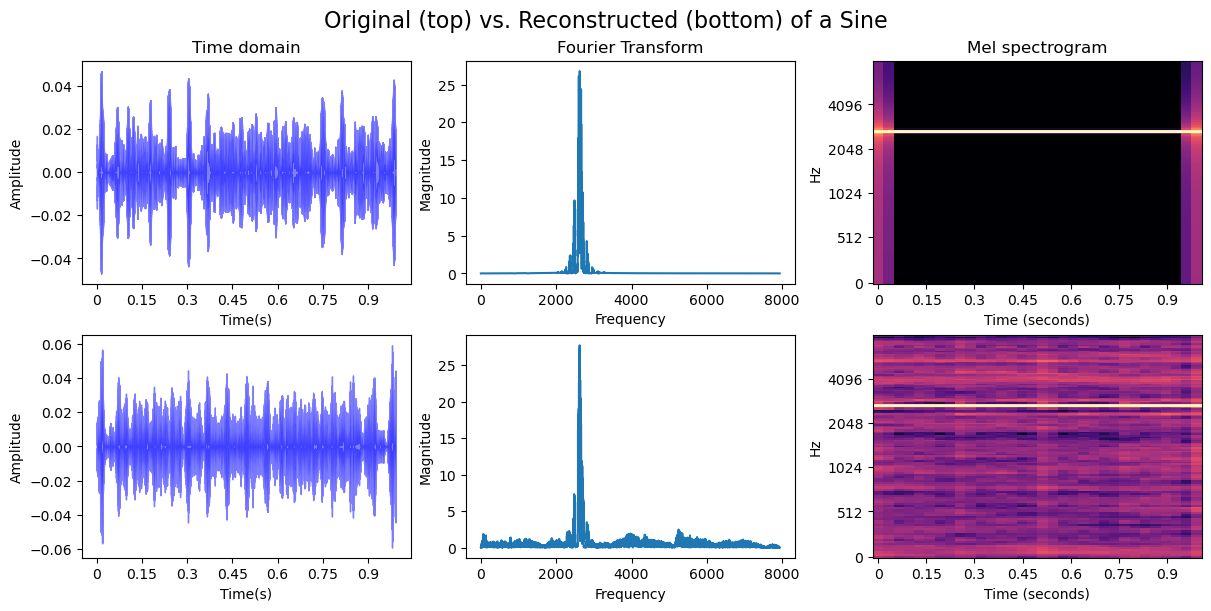

In [177]:
latent_dim = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAEDeepStable(latent_dim, input_shape).to(device)
state_dict = torch.load('./Exports/vae2deepstable_32.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])

fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform, sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon, sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
# plt.savefig('./Figures/Original_vs_Reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
mel_spec = x_hat[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [123]:
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [178]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

In [179]:
idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

Audio(waveform, rate=sr)

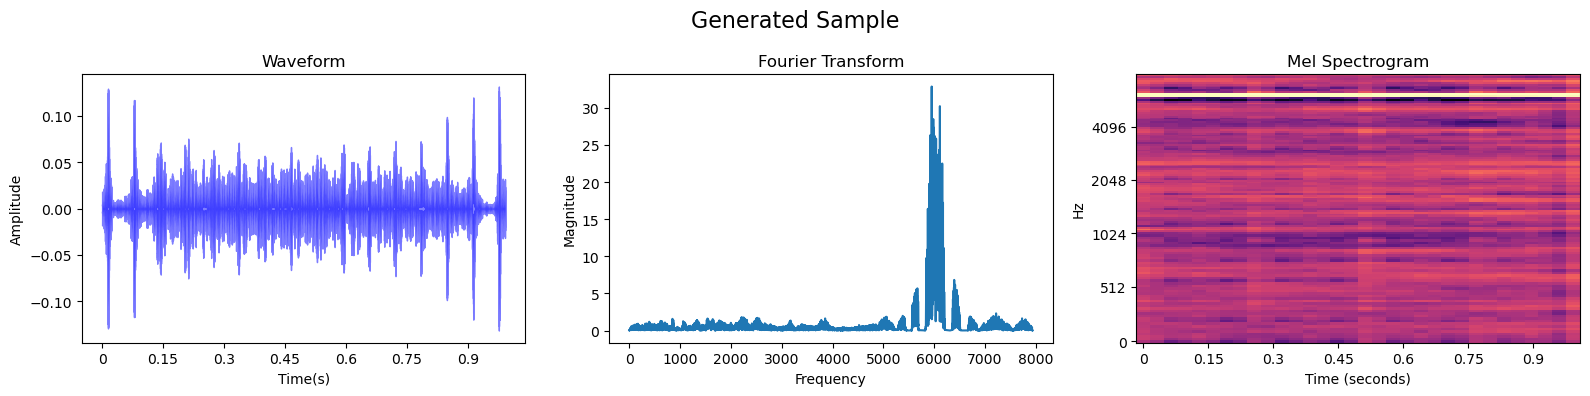

In [203]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

# Random generated mel spectrogram
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

# Waveform
librosa.display.waveshow(waveform, sr=sr, ax=axs[0], alpha=0.5, color='b')
axs[0].set_title('Waveform')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Amplitude')

# Fourier Transform 
ft = np.fft.fft(waveform)
axs[1].plot(np.abs(ft)[:len(ft)//2])
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')

# Mel Spectrogram
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), 
                y_axis='mel', x_axis='s', sr=sr, 
                hop_length=hop_length, ax=axs[2])
axs[2].set_title('Mel Spectrogram')  
# axs[2].set_ylabel('Magnitude')
fig.suptitle('Generated Sample', fontsize=16)  
plt.tight_layout()
plt.show()

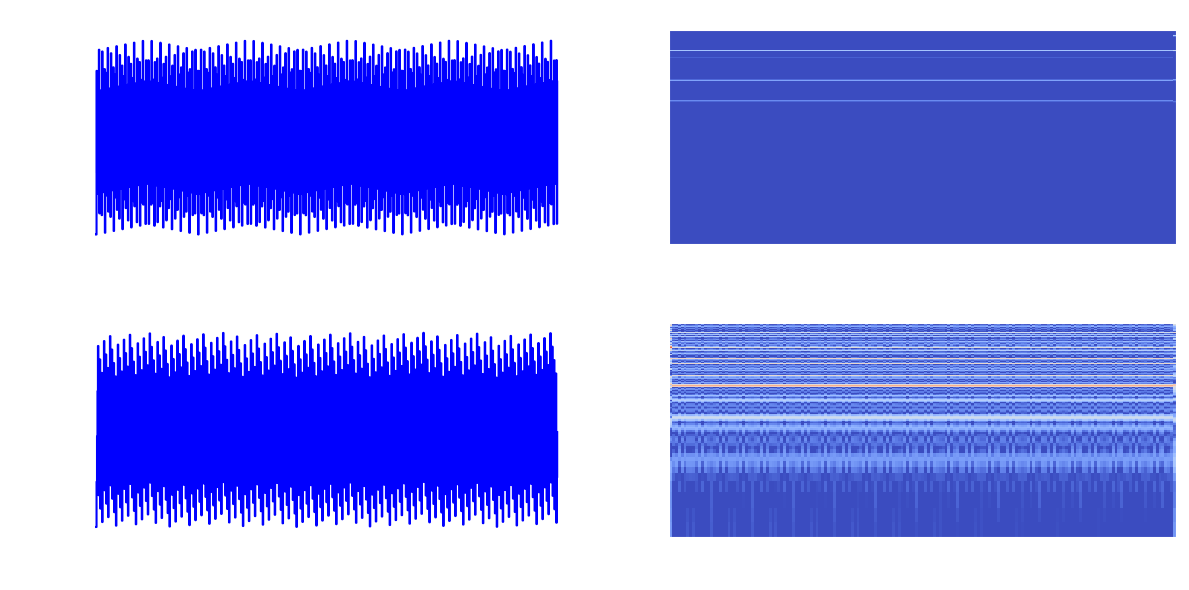

In [104]:
x_batch,spec_batch, y_batch = next(iter(train_loader))
n = 2
idx = np.random.randint(len(x_batch), size=n)
# Plot
fig, axs = plt.subplots(n, 2, figsize=(12,6))
# fig.patch.set_facecolor('none') 
for i in range(n):
  # Waveform 
  librosa.display.waveshow(x_batch[idx[i]].squeeze().detach().cpu().numpy()[:1000], sr=sr, color='b', ax=axs[i, 0])
  # axs[i, 0].plot(x_batch[i].squeeze().detach().cpu().numpy())
  axs[i, 0].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 0].set_xlabel('Time')
  axs[i, 0].set_ylabel('Amplitude')

  # Spectrogram
  # axs[i, 1].imshow(librosa.power_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()), origin="lower", aspect="auto", interpolation="nearest")
  librosa.display.specshow(librosa.amplitude_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()),win_length=512, sr=sr, x_axis='time', y_axis='log', ax=axs[i, 1])
  axs[i, 1].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 1].set_xlabel('Time')
  axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Samples2.png', dpi=300, transparent=True)
plt.show()

torch.Size([1, 1, 512, 172])